# Jet Tagging with Transformers

This notebook shows how to use a Transformer architecture for jet classification between QCD and TT jets using anti-kt clustered particles. The transformer can capture complex interactions between particles through its self-attention mechanism.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from cluster_dataloader_utils import get_dataloaders
from plotting_utils import plot_confusion_matrix, plot_training_history, plot_roc_curve
from utils import load_images

# 1 - Load data 

We are going to use the same data as we did in the deep set. Transformers usually excel at sequential data, but that is not quite what we have here. Instead, we are using the transformer to learn a relationship between the clusters we have found in the data, quite analogous to what we had in the graph neural nets. The actual jet tagging algorithms at CERN have been tried out with all the methods you have seen so far, and transformers seem to be the best performing. You can read more about the theoretical motivation in [this paper](https://arxiv.org/html/2406.08590v1) if you're interested. Do note that we are using simpler data than they are there. 

In [2]:
# Set data path and parameters
batch_size = 64
R = 0.4  # Jet radius parameter
pt_min = 0.01  # Minimum pT threshold
clusters_to_consider = 10
# Get dataloaders
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=batch_size,
    R=R,
    pt_min=pt_min, 
    max_clusters=clusters_to_consider
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 55
Number of validation batches: 8
Number of test batches: 16


# 2- Define the model 

The model is based on the one found in [the paper mentioned earlier](https://arxiv.org/html/2406.08590v1). Note that it differs from many transformers in that there is no positional encoder. In an LLM for instance, the position of a word in a sentence is quite important, whereas here the position of the jets don't matter

In [3]:
class Transformer(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=512, num_heads=4, num_layers=2, output_dim=1):
        super(Transformer, self).__init__()
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Transformer encoder layers
        # this layer implements a transformer as laid out in the paper Attention Is All You Need.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            batch_first=True,
            dropout=0.3,
            activation='gelu'  # Using GELU as in the paper
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Global pooling and classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim)
        )
  
    def forward(self, x):
        # x shape: [batch_size, max_clusters, input_dim]
        
        # Project input
        x = self.input_proj(x)  # Shape: [batch_size, max_clusters, hidden_dim]
        
        # Apply transformer
        x = self.transformer(x)  # Shape: [batch_size, max_clusters, hidden_dim]
        
        # Global pooling (mean over clusters)
        x = x.mean(dim=1)  # Shape: [batch_size, hidden_dim]
        
        # Classification head
        x = self.classifier(x).squeeze()  # Shape: [batch_size, output_dim]
        return x

# 3 - Train the model 

If you looked at the deep set notebook, you might notice that this is the exact same training loop. If you write good code, you can make it into functions and reuse it! 

In [4]:
# Create datasets
# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5,weight_decay=0.01)

# optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# from transformers import get_scheduler
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=1000,
#     num_training_steps=total_steps  # define total_steps appropriately
# )

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for clusters, labels in train_loader:
        clusters, labels = clusters.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(clusters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate accuracy
        preds = (outputs > 0.5).float()
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for clusters, labels in val_loader:
            clusters, labels = clusters.to(device), labels.to(device)
            outputs = model(clusters)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            preds = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()
    
    # Calculate epoch metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = 100. * correct / total
    val_acc = 100. * val_correct / val_total
    
    # Append to history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


Epoch 1/50:
Train Loss: 0.5151, Train Acc: 71.14%
Val Loss: 0.3686, Val Acc: 85.26%
Epoch 2/50:
Train Loss: 0.4037, Train Acc: 79.97%
Val Loss: 0.3253, Val Acc: 85.26%
Epoch 3/50:
Train Loss: 0.3748, Train Acc: 81.68%
Val Loss: 0.3167, Val Acc: 85.66%
Epoch 4/50:
Train Loss: 0.3560, Train Acc: 83.38%
Val Loss: 0.3030, Val Acc: 86.85%
Epoch 5/50:
Train Loss: 0.3430, Train Acc: 84.63%
Val Loss: 0.2957, Val Acc: 87.25%
Epoch 6/50:
Train Loss: 0.3253, Train Acc: 85.77%
Val Loss: 0.2898, Val Acc: 87.45%
Epoch 7/50:
Train Loss: 0.3122, Train Acc: 86.99%
Val Loss: 0.2889, Val Acc: 87.45%
Epoch 8/50:
Train Loss: 0.3106, Train Acc: 86.53%
Val Loss: 0.2895, Val Acc: 87.25%
Epoch 9/50:
Train Loss: 0.3022, Train Acc: 87.78%
Val Loss: 0.2885, Val Acc: 88.84%
Epoch 10/50:
Train Loss: 0.2960, Train Acc: 87.39%
Val Loss: 0.2916, Val Acc: 89.24%
Epoch 11/50:
Train Loss: 0.2857, Train Acc: 88.35%
Val Loss: 0.2870, Val Acc: 88.45%
Epoch 12/50:
Train Loss: 0.2900, Train Acc: 88.49%
Val Loss: 0.2891, Val A

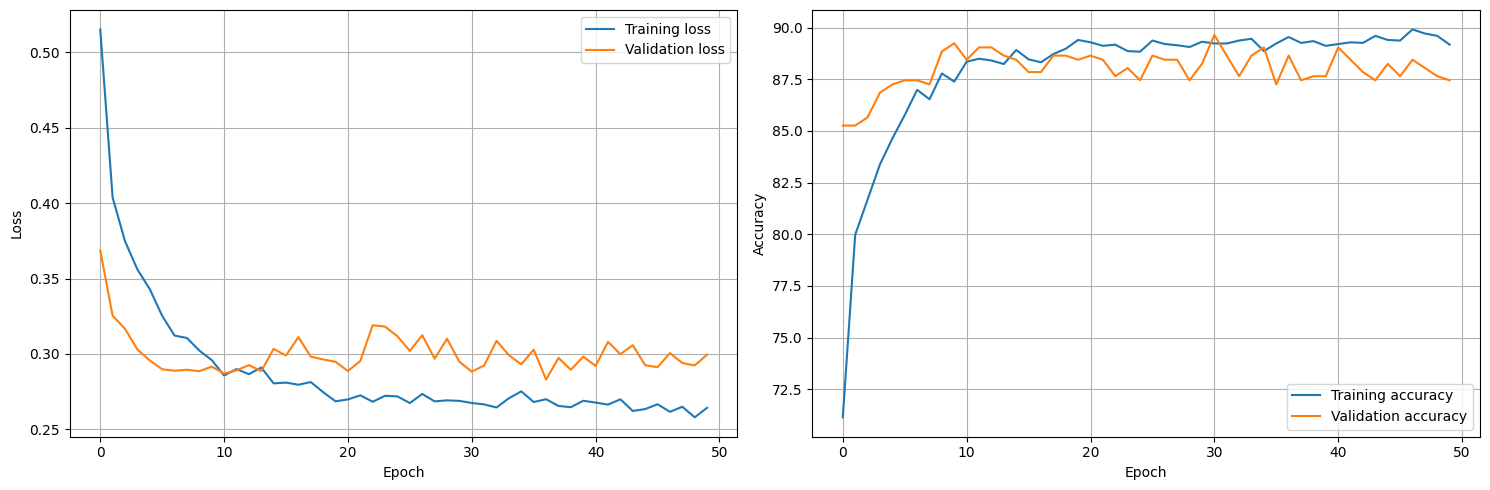

In [5]:
plot_training_history(history, metrics=['loss', 'accuracy'])


# 4 - Evaluating performance

Test Accuracy: 0.8825


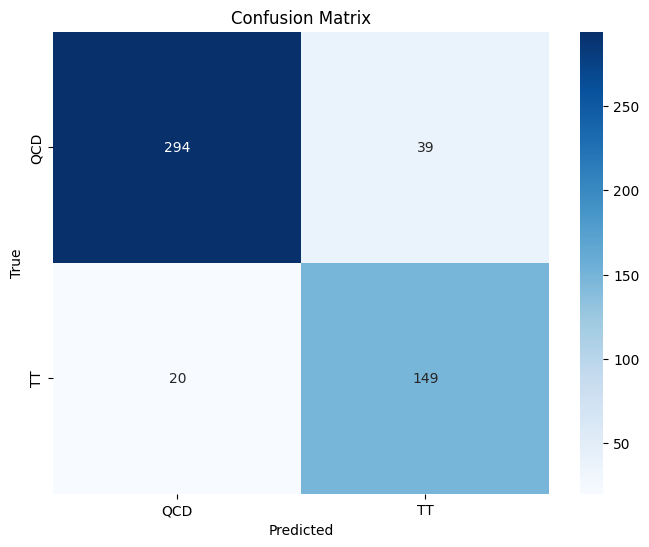

In [6]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for clusters, labels in val_loader:  # Changed 'masks' to 'mask' to match dataset output
        clusters, labels = clusters.to(device), labels.to(device)  # Move mask to device too
        outputs = torch.sigmoid(model(clusters))  #Our output was logits, so we do sigmoid to get the probabilities
        
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds_discrete = np.where(np.array(all_preds) > 0.5, 1, 0)
# Calculate accuracy
accuracy = np.mean(np.array(all_labels) == np.array(all_preds_discrete))
print(f'Test Accuracy: {accuracy:.4f}')

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds_discrete)

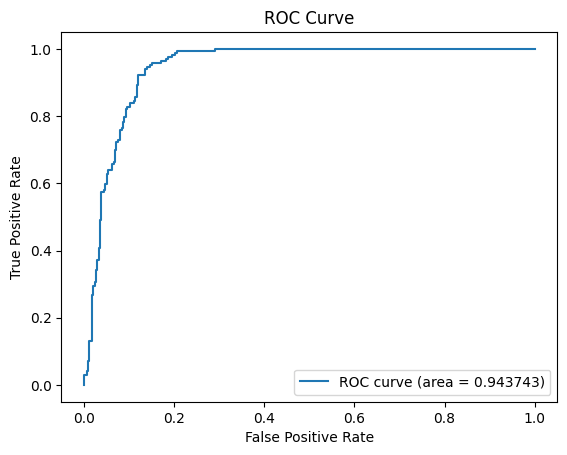

In [7]:
plot_roc_curve(all_labels, all_preds)

# 5 - Make predictions

In [8]:
y_pred_test = []
for data in test_loader:
    data = data[0]
    with torch.no_grad():
        output = model(data.to(device))
        # could you change the prediction threshold? Would that make it better?
        prediction = torch.sigmoid(output).numpy()
        y_pred_test.extend(prediction)

In [9]:
import pandas as pd

# this is a very lazy way to get the test_ids, the data hasn't been shuffled,so they'll be in 
# the same order. In a real example, we'd change the dataloader to also give our test_ids
X_train, y_train, train_ids, X_val_, y_val, val_ids, X_test, test_ids = load_images()


solution = pd.DataFrame({'id':test_ids, 'label':y_pred_test})
solution.to_csv('solution.csv', index=False)